In [1]:
import os, time, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utility import stitch

In [6]:
class RANSAC(stitch):
    def __init__(self, config):
        super(RANSAC, self).__init__(config)
    
    def fit(self, base, addition):
        match_counts = base.shape[0]
        points_base, points_addition = self.expand(base), self.expand(addition)
        outlier_cnt, threshold = match_counts, match_counts * self.outlier_rate
        iter, min_outlier, argmin_H = 0, match_counts, None
        rec = []
        while outlier_cnt > threshold and iter <= self.max_iter:
            # print(iter)
            picked = self.rand_comb(match_counts)
            picked_points_base, picked_points_addition = points_base.T[picked, :2], points_addition.T[picked, :2]
            temp_H = self.homography(picked_points_addition, picked_points_base)
            test_points = temp_H @ points_addition
            test_points = test_points / np.where(test_points[2] != 0, test_points[2], 1)
            outlier_cnt = (np.linalg.norm(points_base[:2] - test_points[:2], axis=0) > self.tolerance).sum()
            rec.append(outlier_cnt)
            iter += 1
            if outlier_cnt < min_outlier:
                min_outlier = outlier_cnt
                argmin_H = temp_H
        return argmin_H, rec
    
class EVOSAC(stitch):
    def __init__(self, config):
        super(EVOSAC, self).__init__(config)
        self.population = config["population"]
        self.lamb = config["mutation_factor"]
    
    # a set must not contain duplicate numbers
    def reproduce(self, parent: np.ndarray, match_counts: int):
        duplicate = True
        # concatenate two chromosome
        combine = parent.flatten()
        while duplicate:
            # adding several random integers (size is based on poisson distribution) to the chromosomes
            # shuffle
            # cut the whole array in half
            # check whether each half contains duplicate numbers
            random = self.rng.choice(range(match_counts), self.rng.poisson(self.lamb, 1)[0], replace=False)
            mutation = np.concatenate([combine, random])
            self.rng.shuffle(mutation)
            c1, c2 = sorted(mutation[0:4]), sorted(mutation[4:8])
            duplicate = False
            for i in range(1, 4):
                if c1[i] == c1[i-1] or c2[i] == c2[i-1]:
                    duplicate = True
                    break
        return c1, c2
    
    def roulette_selection(self, population, fits, pairs):
        fits = fits / np.sum(fits)
        parents = self.rng.choice(population, size=(pairs, 2), replace=True, p=fits)
        return parents
    
    def fit(self, base, addition):
        if self.population % 2:  raise RuntimeError('population must be divisible by 2')
    
        match_counts = base.shape[0]
        points_base, points_addition = self.expand(base), self.expand(addition)
        threshold = match_counts * self.outlier_rate
        iter, max_inlier, argmax_H = 0, 0, None
        population = np.asarray([self.rand_comb(match_counts) for _ in range(self.population)])
        rec = []
        while (match_counts - max_inlier) > threshold and iter <= self.max_iter:
            # print(iter)
            Hs = [self.homography(points_addition.T[points, :2], points_base.T[points, :2]) for points in population]
            fits = [match_counts - self.calculate_outlier(H, points_addition, points_base) for H in Hs]
            argmax_fit = np.argmax(fits)
            rec.append(match_counts - fits[argmax_fit])

            if fits[argmax_fit] > max_inlier:
                max_inlier = fits[argmax_fit]
                argmax_H = Hs[argmax_fit]

            parents = self.roulette_selection(population, fits, population.shape[0] // 2)
            
            # TODO: mutation
            children = np.empty_like(population, dtype=population.dtype)
            for i in range(parents.shape[0]):
                children[2*i], children[2*i+1] = self.reproduce(parents[i], match_counts)
            population = children
            iter += 1
        return argmax_H, rec

In [12]:
info = {}
RANSAC_config = {
    "folder": "./baseline",
    # Since the complexity of match finding is O(N1N2), where Ni is number of key-points.
    # If the image resolution is higher, number of key-points grows too
    # In this case, just lower the resolution would be fine
    "size": None, # resolution (h, w), use None to perserve the original size
    "ratio_test": 0.7,
    'tolerance': 4,
    "outlier_rate": 0.1,
    "max_iter": 500
}
ransac = RANSAC(RANSAC_config)
info["RANSAC_IMG"], info["RANSAC_REC"], info["RANSAC_TIME"] = ransac.run()

In [26]:
EVOSAC_config = {
    "folder": "./baseline",
    "size": None,
    "ratio_test": 0.7,
    'tolerance': 4,
    "outlier_rate": 0.1,
    "max_iter": 500,
    "population": 100,
    'mutation_factor': 0.5
}
evosac = EVOSAC(EVOSAC_config)
info["EVOSAC_IMG"], info["EVOSAC_REC"], info["EVOSAC_TIME"] = evosac.run()

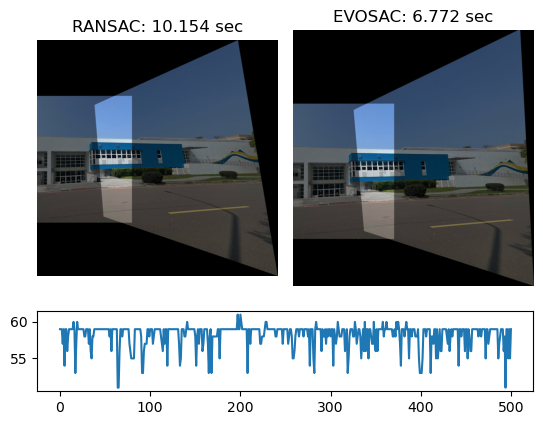

In [27]:
def plot(info):
    gs = gridspec.GridSpec(4, 6)

    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0:3, 0:3])
    ax1.imshow(info["RANSAC_IMG"])
    ax1.set_title(f"RANSAC: {info['RANSAC_TIME']:.3f} sec")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0:3, 3:6])
    ax2.imshow(info["EVOSAC_IMG"])
    ax2.set_title(f"EVOSAC: {info['EVOSAC_TIME']:.3f} sec")
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[-1, 0:3])
    for r in info["RANSAC_REC"]:
        ax3.plot(r)
    ax3.set_xlim(0, max([len(rec) for rec in info["RANSAC_REC"]]))
    ax3.set_title(f"RANSAC outlier record")
        
    ax4 = fig.add_subplot(gs[-1, 3:6])
    for r in info["EVOSAC_REC"]:
        ax4.plot(r)
    ax4.set_xlim(0, max([len(rec) for rec in info["EVOSAC_REC"]]))
    ax4.set_title(f"EVOSAC outlier record")
        
    plt.savefig("result.png", dpi=300)
    plt.show()
    
plot(info)